In [1]:
import numpy as np
import numpy.random as rnd
import os
import sys
import gym
from skimage.color import rgb2gray
from skimage.transform import resize
from collections import deque
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras import backend as K

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
env = gym.make('BreakoutDeterministic-v4')

[2017-05-18 18:03:25,187] Making new env: BreakoutDeterministic-v4


In [3]:
obs = env.reset()

In [4]:
obs.shape

(210, 160, 3)

In [5]:
img = env.render(mode="rgb_array")

<IPython.core.display.Javascript object>


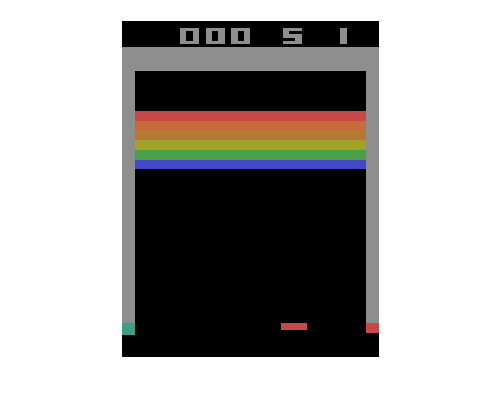

Saving figure Breakout


In [6]:
plt.figure(figsize=(5,4))
plt.imshow(img)
plt.axis("off")
save_fig("Breakout")
plt.show();

In [7]:
def plot_environment(env, figsize=(5,4)):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [8]:
env.action_space

Discrete(4)

In [15]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode="rgb_array")
    frames.append(img)
    if step % n_change_steps == 0:
        action = env.action_space.sample() # play randomly
    obs, reward, done, info = env.step(action)
    if done:
        break

In [16]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, 
                                   fargs=(frames, patch), frames=len(frames), 
                                   repeat=repeat, interval=interval)

<IPython.core.display.Javascript object>


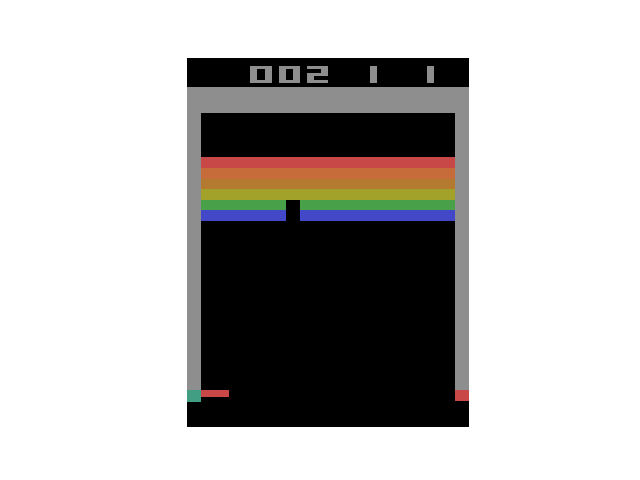

In [17]:
video = plot_animation(frames)
plt.show();

In [13]:
def pre_processing(observe):
    processed_observe = np.uint8(resize(rgb2gray(observe), (84, 84), mode='constant') * 255)
    return processed_observe

In [14]:
plt.imshow(pre_processing(obs), interpolation="nearest", cmap="gray");

In [ ]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (84×84 greyscale)")
plt.imshow(pre_processing(obs), interpolation="nearest", cmap="gray")
plt.axis("off")
save_fig("preprocessing_plot")
plt.show();

In [ ]:
EPISODES = 50000

class DQNAgent:
    def __init__(self, action_size):
        self.render = False
        # environment settings
        self.state_size = (84, 84, 4)
        self.action_size = action_size
        # parameters about epsilon
        self.epsilon = 1.
        self.epsilon_start, self.epsilon_end = 1.0, 0.1
        self.epsilon_decay_step = (self.epsilon_start - self.epsilon_end) / 1000000.
        # parameters about training
        self.batch_size = 32
        self.train_start = 10000
        self.update_target_rate = 10000
        self.discount_factor = 0.99
        self.memory = deque(maxlen=20000)
        self.no_op_steps = 30
        # build model
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()

        self.optimizer = self.optimizer()

        self.avg_q_max, self.avg_loss = 0, 0

    # if the error is in the interval [-1, 1], then the cost is quadratic to the error
    # But outside the interval, the cost is linear to the error
    def optimizer(self):
        a = K.placeholder(shape=(None, ), dtype='int32')
        y = K.placeholder(shape=(None, ), dtype='float32')

        py_x = self.model.output

        a_one_hot = K.one_hot(a, self.action_size)
        q_value = K.sum(py_x * a_one_hot, axis=1)
        error = K.abs(y - q_value)

        quadratic_part = K.clip(error, 0.0, 1.0)
        linear_part = error - quadratic_part
        loss = K.mean(0.5 * K.square(quadratic_part) + linear_part)

        optimizer = RMSprop(lr=0.00025, epsilon=0.01)
        updates = optimizer.get_updates(self.model.trainable_weights, [], loss)
        train = K.function([self.model.input, a, y], [loss], updates=updates)

        return train

    # approximate Q function using Convolution Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        model = Sequential()
        model.add(Conv2D(32, (8, 8), strides=(4, 4), activation='relu', input_shape=self.state_size))
        model.add(Conv2D(64, (4, 4), strides=(2, 2), activation='relu'))
        model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.action_size))
#         model.summary()
        return model

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # get action from model using epsilon-greedy policy
    def get_action(self, history):
        history = np.float32(history / 255.0)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(history)
            return np.argmax(q_value[0])

    # save sample <s,a,r,s'> to the replay memory
    def replay_memory(self, history, action, reward, next_history, dead):
        self.memory.append((history, action, reward, next_history, dead))

    # pick samples randomly from replay memory (with batch_size)
    def train_replay(self):
        if len(self.memory) < self.train_start:
            return
        if self.epsilon > self.epsilon_end:
            self.epsilon -= self.epsilon_decay_step

        mini_batch = random.sample(self.memory, self.batch_size)

        history = np.zeros((self.batch_size, self.state_size[0], self.state_size[1], self.state_size[2]))
        next_history = np.zeros((self.batch_size, self.state_size[0], self.state_size[1], self.state_size[2]))
        target = np.zeros((self.batch_size, ))
        action, reward, dead = [], [], []

        for i in range(self.batch_size):
            history[i] = np.float32(mini_batch[i][0] / 255.)
            next_history[i] = np.float32(mini_batch[i][3] / 255.)
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            dead.append(mini_batch[i][4])

        target_value = self.target_model.predict(next_history)
        
        # like Q Learning, get maximum Q value at s'
        # But from target model
        for i in range(self.batch_size):
            if dead[i]:
                target[i] = reward[i]
            else:
                target[i] = reward[i] + self.discount_factor * np.amax(target_value[i])

        loss = self.optimizer([history, action, target])
        self.avg_loss += loss[0]

    def load_model(self, name):
        self.model.load_weights(name)

    def save_model(self, name):
        self.model.save_weights(name)

In [ ]:
action_size = env.action_space.n
agent = DQNAgent(action_size)
# agent.load_model('./Breakout_DQN.h5')

scores, episodes, global_step = [], [], 0

for e in range(EPISODES):
    done = False
    dead = False
    # 1 episode = 5 lives
    step, score, start_life = 0, 0, 5
    observe = env.reset()

    # this is one of DeepMind's idea.
    # just do nothing at the start of episode to avoid sub-optimal
    for _ in range(random.randint(1, agent.no_op_steps)):
        observe, _, _, _ = env.step(1)

    # At start of episode, there is no preceding frame. So just copy initial states to make history
    state = pre_processing(observe)
    history = np.stack((state, state, state, state), axis=2)
    history = np.reshape([history], (1, 84, 84, 4))

    while not done:
        if agent.render:
            env.render()
        global_step += 1
        step += 1

        # get action for the current history and go one step in environment
        action = agent.get_action(history)
        observe, reward, done, info = env.step(action)
        # pre-process the observation --> history
        next_state = pre_processing(observe)
        next_state = np.reshape([next_state], (1, 84, 84, 1))
        next_history = np.append(next_state, history[:, :, :, :3], axis=3)

        agent.avg_q_max += np.amax(agent.model.predict(np.float32(history / 255.))[0])

        # if the ball is fall, then the agent is dead --> episode is not over
        if start_life > info['ale.lives']:
            dead = True
            start_life = info['ale.lives']

        reward = np.clip(reward, -1., 1.)

        # save the sample <s, a, r, s'> to the replay memory
        agent.replay_memory(history, action, reward, next_history, dead)
        # every some time interval, train model
        agent.train_replay()
        # update the target model with model
        if global_step % agent.update_target_rate == 0:
            agent.update_target_model()

        score += reward

        # if agent is dead, then reset the history
        if dead:
            dead = False
        else:
            history = next_history

        # if done, plot the score over episodes
        if done:
            print("\repisode:", e, "  score:", score, "  memory length:", len(agent.memory),
                  "  epsilon:", agent.epsilon, "  global_step:", global_step, "  average_q:", agent.avg_q_max/float(step),
                  "  average loss:", agent.avg_loss/float(step), end="")

            agent.avg_q_max, agent.avg_loss = 0, 0

        if e % 1000 == 0:
            agent.save_model("./Breakout_DQN.h5")